This notebook explores s-process exposures.

This section checks if you have the required python packages installed. If you do have them installed, it will simply skip this step, if not, it will install them for you within the notebook's container

In [1]:
import sys, subprocess,pkg_resources
required = {'numpy','wnutils','matplotlib','ipython','scipy'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

This notebook uses [wnutils](https://wnutils.readthedocs.io) to analyze the nucleosyntheis [XML](https://www.w3.org/TR/REC-xml/) output, so we import that package with other needed.

In [2]:
import wnutils.xml as wx
import numpy as np
import matplotlib.pyplot as plt
import requests
import math
from matplotlib import animation, rc
from IPython.display import HTML
from scipy.integrate import quad,simps
from os import path

The next step is to make available the data then run the calculations.

In [3]:
if not path.exists('sproc.xml'):
    url = 'https://raw.githubusercontent.com/jaadt7/notebook/main/sproc.xml'
    filename = 'sproc.xml'
    r = requests.get(url)
    f = open(filename,"w") 
    f.write(r.text)  
sproc = wx.Xml('sproc.xml')

Helium burning creates a carbon/oxygen core in the star.  If the core becomes [degenerate](https://en.wikipedia.org/wiki/Degenerate_matter#Degenerate_gases) at this stage, it is able to sustain itself against further gravitational contraction without further nuclear burning.  The reason is that radiation loss normally leads to a loss of energy from the core, which means the pressure decreases.  Nuclear burning releases energy and maintains the necessary pressure.  For degenerate matter, however, the pressure is simply maintained by the fact that no two electrons can exist in the same quantum mechanical state (the [Pauli exclusion principle](https://en.wikipedia.org/wiki/Pauli_exclusion_principle).  At high density, this fact allows there to be strong pressure even at low temperature.

Outside the carbon/oxygen core, helium-rich matter exists and can undergo helium burning.  The ashes of this burning ($^{12}$C and $^{16}$O) settle onto the core and increase the core's mass.  The burning is in fact a complicated and alternating interplay of shell helium burning and shell hydrogen burning outside the helium burning, with mixing occurring between the various shell burnings.  This is the burning that occurs during the star's life on the [asymptotic giant branch](https://en.wikipedia.org/wiki/Asymptotic_giant_branch).  During this phase, [s-processing](https://en.wikipedia.org/wiki/S-process) can occur.

The present calculation modeled s-process nucleosynthesis by running the ashes of helium burning at constant temperature, density, and neutron density, which are printed in the next cell.

In [4]:
props = sproc.get_properties_as_floats(['time','t9', 'rho',('exposure','n')])
x_n = sproc.get_mass_fractions(['n'])['n']
n_n = x_n[len(x_n)-1] * props['rho'][len(props['rho'])-1] * 6.022e23
print('For the calculation, the duration, temperature, mass density, and neutron density were:')
print('   time (yr) = {0:.2e}'.format(props['time'][len(props['time'])-1] / 3.15e7))
print('   T (K) = {:.2e}'.format(props['t9'][len(props['t9'])-1] * 1.e9))
print('   mass density (g/cc) = {:.2e}'.format(props['rho'][len(props['rho'])-1]))
print('   neutron density (per cc) = {:.2e}'.format(n_n))

For the calculation, the duration, temperature, mass density, and neutron density were:
   time (yr) = 1.00e+05
   T (K) = 2.50e+08
   mass density (g/cc) = 1.00e+03
   neutron density (per cc) = 1.00e+08


The neutron exposure grows with time.

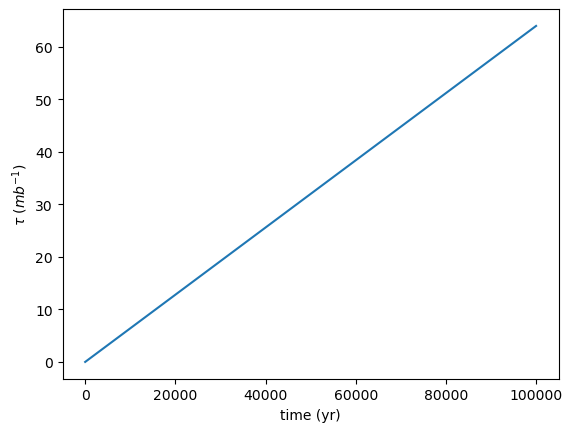

In [5]:
sproc.plot_property_vs_property('time', ('exposure','n'), xfactor = 3.15e7, xlabel='time (yr)', ylabel='$\\tau\ (mb^{-1})$')

View the abundances versus mass number for several exposures (chosen by XPath).

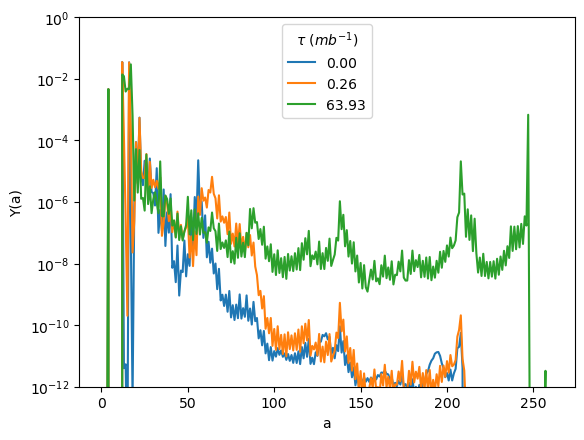

In [6]:
my_zone_xpath = '[(position() = 1) or (position() = 110) or (position() = last())]'
zone_data = sproc.get_zone_data(my_zone_xpath)
tau1 = ["{:.2f}".format(float(zone1['properties'][('exposure', 'n')])) for zone1 in zone_data.values()]
sproc.plot_abundances_vs_nucleon_number(zone_xpath=my_zone_xpath, yscale = 'log', ylim = [1.e-12,1], legend=(tau1, {'title': '$\\tau\ (mb^{-1}$)'}))

View an animation that shows the variation of the abundances as function of mass number as time & exposure move forward

In [7]:
rc_params = {'lines.linewidth': 2}
p_params = {'color': 'black'}

def my_title(props, i):
     title_str = \
     r"time (s) = %8.2e, $\tau (mb^{-1})$ = %0.2e" %\
     (props['time'][i],props[('exposure','n')][i])
     return title_str

bind = lambda i: my_title(props, i)
movie = sproc.make_abundances_vs_nucleon_number_movie(rcParams = rc_params,plotParams = p_params
                                              ,title_func=bind,xlim = [0,250],ylim=[1e-12,1],yscale='log'
                                             ,xlabel='A, Mass Number',ylabel = 'Abundance Y(A)')
HTML(movie.to_jshtml())

Average over exposures.  This could be much better: split up.  Change tau_0 for different averages. In the following cell, determine the density you wish to integrate over with its appropriate parameters. So far, the choices are normalized decaying exponential with characteristic exposure $\tau_0$, a Gaussian with mean $\mu$ and standard deviation $\sigma$, or a Poisson Distribution of given rate $\lambda$

In the following cell, we define the distribution functions we wish to test

In [8]:
def exp_dis(props,tau_0):
    return np.exp(-props[('exposure','n')] / tau_0) / tau_0
def exp_dis_int(x,tau_0):
    return np.exp(-x/tau_0)/tau_0
def gauss_dis(props,mu,sigma):
    exp_arg = 0.5*np.power((props[('exposure','n')]-mu)/sigma,2)
    return np.exp(-exp_arg)/(sigma*np.power(2*np.pi,0.5))
def gauss_dis_int(x,mu,sigma):
    exp_arg = 0.5*np.power((x-mu)/sigma,2)
    return np.exp(-exp_arg)/(sigma*np.power(2*np.pi,0.5))
def poisson_dis(props,lmbda): # using Sterling's approximation for the factorial
    expsr_fctrl = np.exp(props[('exposure','n')]*np.log(props[('exposure','n')])-props[('exposure','n')])
    return np.power(lmbda,props[('exposure','n')])*np.exp(-lmbda)/expsr_fctrl

In the below cell, we perform the integration over the density function and apply the Gaver-Stehfest method to find the density of cross sections. For the choice of function, the choice variable is a string that takes the option of exp, gauss, poiss to select decaying exponential, gaussian distribution, and poisson distribution respectively

In [9]:
plt.clf() #to clear any arguments from previous plots, for some reason they were showing up in the next plots

nucs = sproc.get_nuclide_data()
y = sproc.get_all_abundances_in_zones()

rho_tau = np.array(y.shape[0])

tau_0 = 3
sigma = 1
mu = 5
lmbda = 3 #since lambda is a built-in python variable, the 'a' was removed to avoid any conflicts

choice = 'poiss'

if choice == 'exp':
    rho_tau = exp_dis(props,tau_0)
    w = quad(lambda  x: exp_dis_int(x,tau_0),0,np.infty)[0]
elif choice == 'gauss':
    rho_tau = gauss_dis(props,mu,sigma)
    w = quad(lambda x: gauss_dis_int(x,mu,sigma),0,np.infty)[0]
elif choice =='poiss':
    rho_tau = poisson_dis(props,lmbda)
    w = simps(rho_tau) #simpson method used to integrate the density of a poisson distribution. Other methods were diverging
    

# Create an array of dtaus.

dtau = np.diff(props[('exposure','n')])


ya_sum = np.zeros(y.shape[1] + y.shape[2])

for z in range(y.shape[1]):
    for n in range(y.shape[2]):
        ya_sum[z+n] += np.trapz(y[:,z,n] * rho_tau,dx=dtau)
ya_sum  =ya_sum/w

Plot abundances averaged over exposures.

<Figure size 640x480 with 0 Axes>

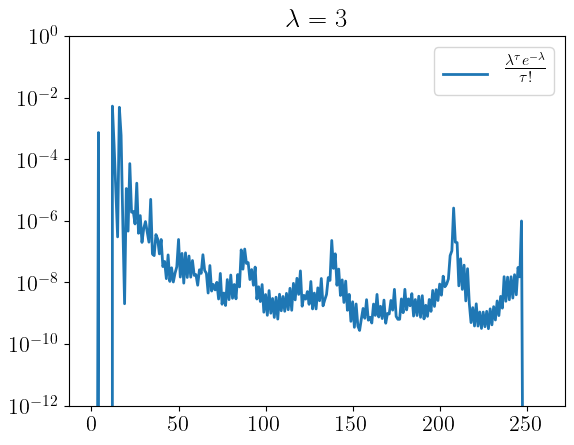

In [10]:
plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 16

if choice == 'exp':
    plt.title(r'$\tau_{0} =$' + str(tau_0) + ' $mb^{-1}$')
    plt.plot(ya_sum,label = r'$\rho(\tau)=\frac{1}{\tau_{0}}e^{-\frac{\tau}{\tau_{0}}}$')
elif choice =='gauss':
    plt.title(r'$\mu =$' + str(mu) + r' , $\sigma = $'+str(sigma))
    plt.plot(ya_sum,label = r'$\rho(\tau)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\left(\frac{\tau - \mu}{\sigma}\right)^{2}}$')
elif choice == 'poiss':
    plt.title(r'$\lambda$ = '+str(lmbda))
    plt.plot(ya_sum, label = r'$\frac{\lambda^{\tau}e^{-\lambda}}{\tau!}$')

plt.yscale('log')
plt.ylim([1.e-12,1])
plt.legend()
plt.show()

Now we initiate the necessary functions to integrate the inverse Laplace transform via the Gaver-Stehfest method. 'm' controls the number of terms in the sum. The following python lines are commented until the proper data can be plugged in to be used.

In [ ]:
"""
def w_k(m,k):
    sum = 0
    for j in range(math.floor((k+1)/2),np.min([m,k])+1):
        sum =sum +np.power(j,m+1)*binom(m,j)*binom(2*j,j)*binom(j,k-j)/math.factorial(m)
    return np.power(-1,m+k)*sum

m=7
wk = np.empty(2*m)
for i in range(2*m):
    wk[i] = w_k(m,i+1)

for i in range(0,k+1):
    for j in range(2*m):
        f_calc = f_calc + np.log(2)*wk[j]*lap_trans_poisson((j+1)*np.log(2)/t,i)/t 
"""